In [1]:
import unicodedata
import string
import re
import random
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from io import open

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SOS_token = 0
EOS_token = 1

In [4]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.word2count = {}
        self.n_words = 2
    
    def add_sentence(self, sentence):
        for word in sentence.split(" "):
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


class EncoderS2S(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, x, h0):
        embedded = self.embedding(x).view(1, 1, -1)
        x = embedded
        x, h = self.gru(x, h0)
        return x, h
    
    def zero_hidden(self, device):
        return torch.zeros(1, 1, self.hidden_size, device=device)


# TODO: try training a simple seq-to-seq model
class DecoderS2S(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # Input & output size are the same (since they are word embeddings)
        self.input_size = input_size
        self.output_size = input_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h0):
        embedded = self.embedding(x).view(1, 1, -1)
        x = F.relu(embedded)
        x, h = self.gru(x, h0)
        # GRU output has leading batch dimension, so index x[0]
        x = self.out(x[0])
        x = self.softmax(x)
        return x
    
    def zero_hidden(self, device):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    
class AttnDecoderS2S(nn.Module):
    def __init__(self, input_size, hidden_size, max_length, dropout_p=0.1):
        super().__init__()
        self.input_size = input_size
        self.output_size = input_size
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        # Weights for each word in sentence of max length
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(p = self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, h0, yhats_encoder):
        embedded = self.embedding(x).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        x = torch.concat((embedded[0], h0[0]), dim=1)
        attn_weights = F.softmax(
            self.attn(x),
            dim=1
        )
        
        # unsqueeze(0) --> add 'batch' dimension back to
        # attention weights & add to encoder outputs
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),
            yhats_encoder.unsqueeze(0)
        )
        
        # subscript embedded & attn_applied to emove 'batch' dimension
        x = torch.concat((embedded[0], attn_applied[0]), dim=1)
        # unsqueeze result to add 'batch' dimension back in
        x = self.attn_combine(x).unsqueeze(0)
        x = F.relu(x)
        
        x, h = self.gru(x, h0)
        # GRU output has leading batch dimension, so index x[0]
        x = self.out(x[0])
        x = F.log_softmax(x, dim=1)
        return x, h, attn_weights
    
    def zero_hidden(self, device):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
def unicode_to_ascii(s):
    """Turn a Unicode string to plain ASCII.
    """
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )


def normalize_string(s):
    """Lowercase, trim, and remove non-letter characters.
    """
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


def read_langs(lang1, lang2, data_path="../data/rnn_seq_to_seq_data", reverse=False):
    print("Reading lines...")
    
    # Read file & split into lines
    lines = open(f"{data_path}/{lang1}-{lang2}.txt", encoding="utf-8").read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs


def filter_pair(p, max_length, eng_prefixes):
    return len(p[0].split(" ")) < max_length and \
        len(p[1].split(" ")) < max_length and \
        p[1].startswith(eng_prefixes)


def filter_pairs(pairs, max_length, eng_prefixes):
    return [pair for pair in pairs if filter_pair(pair, max_length, eng_prefixes)]


def prepare_data(lang1, lang2, max_length, eng_prefixes, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse=reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filter_pairs(pairs, max_length, eng_prefixes)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]


def tensor_from_sentence(lang, sentence, device):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensors_from_pairs(pair, input_lang, output_lang, device):
    input_tensor = tensor_from_sentence(input_lang, pair[0], device)
    target_tensor = tensor_from_sentence(output_lang, pair[1], device)
    return input_tensor, target_tensor


def as_minutes(s):
    m = int(np.round(s // 60))
    s = int(np.round(s % 60))
    return f"{m}m {s}s"


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return f"{as_minutes(s)} (- {as_minutes(rs)})"


def train(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, input_tensor, target_tensor, max_length, device, teacher_forcing_ratio=0.5):
    h_encoder = encoder.zero_hidden(device)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.shape[0]
    target_length = target_tensor.shape[0]
    
    yhats_encoder = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0.0
    for ei in range(input_length):
        yhat_encoder, h_encoder = encoder(input_tensor[ei], h_encoder)
        yhats_encoder[ei] = yhat_encoder[0, 0]
        
    x_decoder = torch.tensor([[SOS_token]], device=device)
    h_decoder = h_encoder
    
    use_teacher_forcing = True if np.random.uniform() < teacher_forcing_ratio else False
    
    # Teacher forcing = feed target in as next input
    if use_teacher_forcing:
        for di in range(target_length):
            # Pass in full encoder output
            yhat_decoder, h_decoder, attn_decoder = decoder(x_decoder, h_decoder, yhats_encoder)
            loss += criterion(yhat_decoder, target_tensor[di])
            
            x_decoder = target_tensor[di]
    # Non-teacher forcing = feed previous output of decoder as input
    else:
        for di in range(target_length):
            yhat_decoder, h_decoder, attn_decoder = decoder(x_decoder, h_decoder, yhats_encoder) 
            loss += criterion(yhat_decoder, target_tensor[di])
            
            topv, topi = yhat_decoder.topk(1)
            # When used as input, should be detached from backprop history
            x_decoder = topi.squeeze().detach()
            if x_decoder.item() == EOS_token:
                break
    
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length


def train_iters(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, n_iters, input_lang, output_lang, max_length, device, teacher_forcing_ratio=0.5, print_every=1000, plot_every=100):
    start_time = time.time()
    plot_losses = []
    # Reset by print_every
    print_loss_total = 0.0
    # Reset by plot_every
    plot_loss_total = 0.0
    
    encoder.train()
    decoder.train()
    training_pairs = [tensors_from_pairs(random.choice(pairs), input_lang, output_lang, device) for _ in range(n_iters)]
    for itr in range(1, n_iters + 1):
        input_tensor, target_tensor = training_pairs[itr - 1]
        
        loss = train(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, input_tensor, target_tensor, max_length, device, teacher_forcing_ratio)
        print_loss_total += loss
        plot_loss_total += loss
        
        if itr % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0.0
            print(f"{time_since(start_time, itr / n_iters)} ({itr}, {np.round(itr / n_iters * 100, 1)}) {np.round(print_loss_avg, 3)}")
        
        if itr % plot_every == 0:
            # TODO
            pass


def evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length, device):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence, device)
        input_length = input_tensor.shape[0]
        h_encoder = encoder.zero_hidden(device)
        
        yhats_encoder = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):
            yhat_encoder, h_encoder = encoder(input_tensor[ei], h_encoder)
            yhats_encoder[ei] += yhat_encoder[0, 0]
            
        x_decoder = torch.tensor([[SOS_token]], device=device)
        h_decoder = h_encoder
        
        decoded_words = []
        attns_decoder = torch.zeros(max_length, max_length)
        
        # TODO: implement beam search
        for di in range(max_length):
            yhat_decoder, h_decoder, attn_decoder = decoder(x_decoder, h_decoder, yhats_encoder)
            attns_decoder[di] = attn_decoder.detach()
            
            topv, topi = yhat_decoder.detach().topk(1)
            if topi.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                
            x_decoder = topi.squeeze().detach()
            
        return decoded_words, attns_decoder[:di + 1]


def evaluate_rand(encoder, decoder, pairs, input_lang, output_lang, max_length, device, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print("=>", pair[0])
        print("==", pair[1])
        yhats, attns = evaluate(encoder, decoder, pair[0], input_lang, output_lang, max_length, device)
        output_sentence = ' '.join(yhats)
        print("<=", output_sentence)
        print('')
        
        
def show_attns(input_sentence, output_words, attns):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attns.numpy(), cmap="bone")
    fig.colorbar(cax)
    ax.set_xticklabels(
        [''] + input_sentence.split(' ') + ["<EOS>"],
        rotation=90
    )
    ax.set_yticklabels([''] + output_words)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    

def evaluate_and_show_attns(encoder, decoder, input_sentence, input_lang, output_lang, max_length, device):
    output_words, attns = evaluate(
        encoder,
        decoder,
        input_sentence,
        input_lang,
        output_lang,
        max_length,
        device
    )
    print(f"Input: {input_sentence}")
    print(f"Output: {' '.join(output_words)}")
    show_attns(input_sentence, output_words, attns)

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

In [7]:
input_lang, output_lang, pairs = prepare_data("eng", "fra", MAX_LENGTH, eng_prefixes, reverse=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


In [8]:
hidden_size = 256
lr = 0.001
n_iters = int(6e4)

In [9]:
encoder = EncoderS2S(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderS2S(output_lang.n_words, hidden_size, MAX_LENGTH).to(device)

In [10]:
# encoder_optimizer = optim.SGD(encoder.parameters(), lr=lr)
# decoder_optimizer = optim.SGD(attn_decoder.parameters(), lr=lr)
encoder_optimizer = optim.AdamW(encoder.parameters(), lr=lr)
decoder_optimizer = optim.AdamW(attn_decoder.parameters(), lr=lr)

criterion = nn.NLLLoss()

In [11]:
train_iters(
    encoder,
    attn_decoder,
    encoder_optimizer,
    decoder_optimizer,
    criterion,
    n_iters,
    input_lang,
    output_lang,
    MAX_LENGTH,
    device,
    print_every=int(1e3)
)

0m 55s (- 53m 40s) (1000, 1.7) 3.117
1m 38s (- 47m 12s) (2000, 3.3) 2.709
2m 22s (- 45m 4s) (3000, 5.0) 2.485
3m 6s (- 43m 20s) (4000, 6.7) 2.281
3m 50s (- 42m 8s) (5000, 8.3) 2.176
4m 33s (- 40m 59s) (6000, 10.0) 2.053
5m 17s (- 40m 3s) (7000, 11.7) 1.971
5m 58s (- 38m 44s) (8000, 13.3) 1.801
6m 36s (- 37m 22s) (9000, 15.0) 1.753
7m 13s (- 36m 7s) (10000, 16.7) 1.679
7m 52s (- 35m 2s) (11000, 18.3) 1.605
8m 30s (- 34m 1s) (12000, 20.0) 1.512
9m 9s (- 33m 3s) (13000, 21.7) 1.466
9m 46s (- 32m 5s) (14000, 23.3) 1.471
10m 24s (- 31m 11s) (15000, 25.0) 1.454
11m 2s (- 30m 21s) (16000, 26.7) 1.421
11m 41s (- 29m 33s) (17000, 28.3) 1.283
12m 20s (- 28m 47s) (18000, 30.0) 1.348
12m 58s (- 27m 60s) (19000, 31.7) 1.279
13m 40s (- 27m 19s) (20000, 33.3) 1.188
14m 19s (- 26m 35s) (21000, 35.0) 1.229
15m 1s (- 25m 57s) (22000, 36.7) 1.255
15m 46s (- 25m 22s) (23000, 38.3) 1.157
16m 30s (- 24m 45s) (24000, 40.0) 1.154
17m 8s (- 23m 60s) (25000, 41.7) 1.133
17m 46s (- 23m 14s) (26000, 43.3) 1.09
18

In [12]:
evaluate_rand(encoder, attn_decoder, pairs, input_lang, output_lang, MAX_LENGTH, device)

=> tu agis comme une enfant .
== you re acting like a child .
<= you re acting like a child . <EOS>

=> je ne vais pas perdre mon temps .
== i m not wasting my time .
<= i m not wasting my time . <EOS>

=> nous en sommes toutes certaines .
== we re all sure of that .
<= we re all sure of that . <EOS>

=> elle ecrit des nouvelles .
== she is a short story writer .
<= she is a bad again . <EOS>

=> je suis pleine de ressources .
== i m resourceful .
<= i m resourceful . <EOS>

=> je suis un puriste .
== i m a purist .
<= i m a purist . <EOS>

=> tu es enseignante .
== you are a teacher .
<= you are a teacher . <EOS>

=> vous etes mignon dans votre genre .
== you re kind of cute .
<= you re kind of cute . <EOS>

=> vous etes encore jeune .
== you re still young .
<= you re still young . <EOS>

=> tu es inquiete pas vrai ?
== you re worried aren t you ?
<= you re worried aren t you ? <EOS>



Input: je suis detendu .
Output: i m relaxed . <EOS>


/tmp/ipykernel_136/504901754.py:225: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/tmp/ipykernel_136/504901754.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


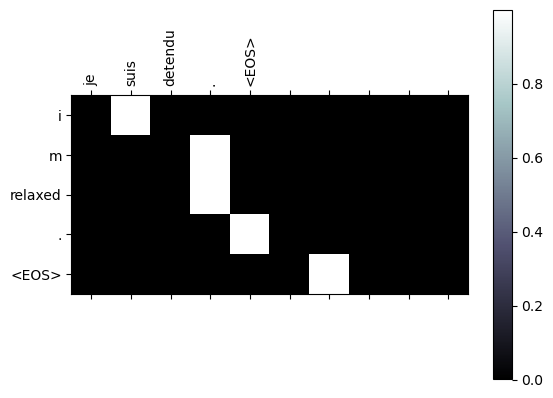

In [22]:
evaluate_and_show_attns(
    encoder,
    attn_decoder,
    # "je suis trop froid .",
    "je suis detendu .",
    input_lang,
    output_lang,
    MAX_LENGTH,
    device
)

Input: elle a cinq ans de moins que moi .
Output: she s three years older than i am . <EOS>


/tmp/ipykernel_136/504901754.py:225: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/tmp/ipykernel_136/504901754.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


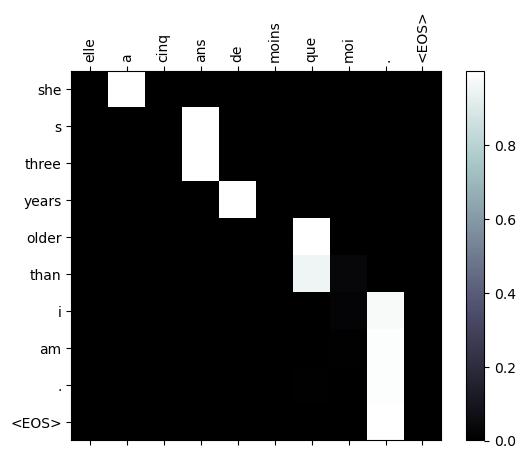

Input: elle est trop petit .
Output: she is too short . <EOS>


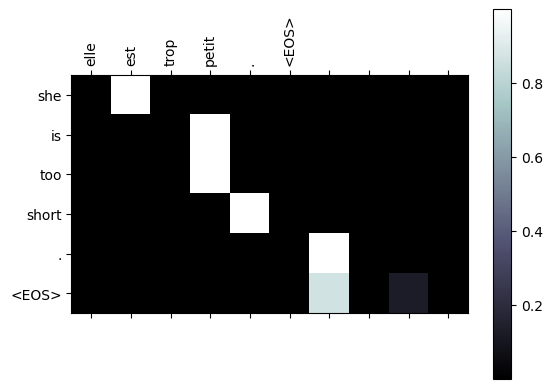

Input: je ne crains pas de mourir .
Output: i m not afraid of death . <EOS>


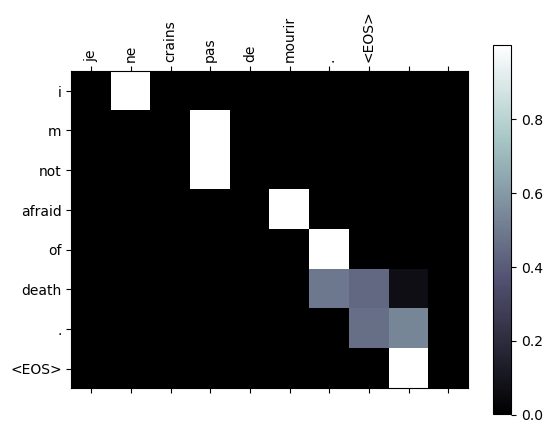

Input: c est un jeune directeur plein de talent .
Output: he s a talented talented with . <EOS>


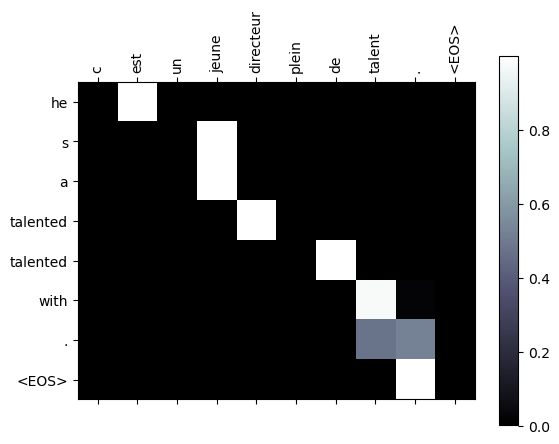

In [16]:
input_sentences = [
    "elle a cinq ans de moins que moi .",
    "elle est trop petit .",
    "je ne crains pas de mourir .",
    "c est un jeune directeur plein de talent ."
]

for inp_s in input_sentences:
    evaluate_and_show_attns(
        encoder,
        attn_decoder,
        inp_s,
        input_lang,
        output_lang,
        MAX_LENGTH,
        device
    )